# Реализация логистической регрессии в TensorFlow

derived from: https://github.com/a4tunado/lectures/blob/master/cv/004/004-classification.ipynb


In [1]:
import numpy as np
import tensorflow as tf

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

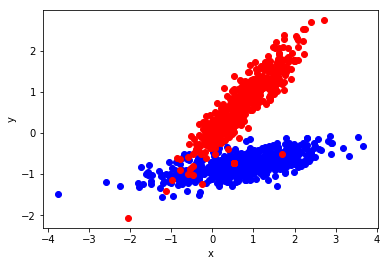

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

In [5]:
X.shape, y.shape

((1000, 2), (1000, 1))

## Вспомогательная функция для создания операций

In [6]:
import random
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(random.choices(string.ascii_letters, k = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной операций

In [7]:
np.array([0,1,2])[:2]

array([0, 1])

In [8]:
def linear_op_forward(X, W, B):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T) + B  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    B = op.inputs[2]  # bias
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads), axis = 0, keep_dims = True)
    dB = tf.reduce_sum(grads, axis = 0,  keep_dims = False)
    return dX, dW, dB

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1.0 / (1.0 + np.exp(-X))
    
# compute sigmoid
def SigmoidT(T):
    return 1.0/(1.0 + tf.exp(-T))

#compute sigmoid derivative: S' = S(1-S)
def SigmoidPrimeT(T):
    return T *( 1.0 - T)

def sigmoid_op_backward(op, grads):
    # TODO: реализовать вычисление градиента для sigmoid
    X = op.inputs[0]
    return tf.reduce_sum(tf.multiply(SigmoidPrimeT(SigmoidT(X)), grads ), axis = 0, keep_dims = True)

In [9]:
tf.zeros_like(X).shape

TensorShape([Dimension(1000), Dimension(2)])

## Создание графа вычислений и обучение модели

In [10]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    var_B = tf.Variable(tf.random_uniform(shape = [ 1],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W, var_B],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.9).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(50):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 50 == 0:
                print('[%03d] loss=%.3f weights=%s bias=%s' % (steps, loss, var_W.eval(), var_B.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()
    bias = var_B.eval()
    print (weights[0, 0] / weights[0, 1], (bias[0])/weights[0, 1])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
[000] loss=0.785 weights=[[0.40704343 0.1949992 ]] bias=[0.4008907]
[050] loss=0.595 weights=[[ 0.22764139 -2.181779  ]] bias=[-0.4889989]
[100] loss=0.584 weights=[[ 0.55218667 -3.1059434 ]] bias=[-0.86069113]
[150] loss=0.544 weights=[[ 0.7855609 -3.692563 ]] bias=[-1.151893]
[200] loss=0.566 weights=[[ 0.9663364 -4.129743 ]] bias=[-1.3871602]
[250] loss=0.532 weights=[[ 1.1000154 -4.4896965]] bias=[-1.5670402]
[300] loss=0.545 weights=[[ 1.2111666 -4.7919283]] bias=[-1.7289802]
[350] loss=0.532 weights=[[ 1.3016047 -5.05905  ]] bias=[-1.8650054]
[400] loss=0.582 weights=[[ 1.374882 -5.296655]] bias=[-1.9892043]
[450] loss=0.541 weights=[[ 1.447196 -5.51435 ]] bias=[-2.08613]
-0.26331258 0.3824307


## Визуализируем кривую обучения

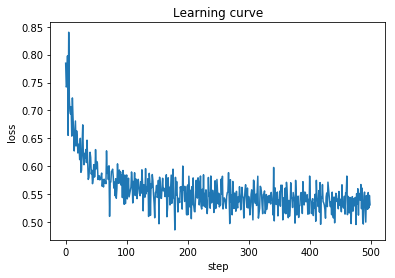

In [11]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

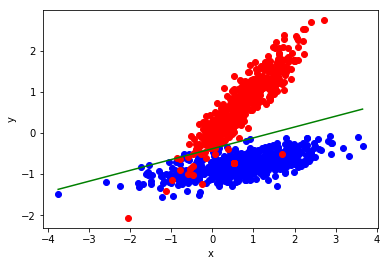

In [12]:
y_pred =  - (X[:, 0] * weights[0, 0]  + bias[0])/ weights[0, 1] #/bias[0,1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');

## Compare to canonical implementation
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/logistic_regression.py

In [13]:
train_label_ohe = np.eye(2)[y.ravel()].astype(np.float32)

In [14]:
train_label_ohe[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
W = tf.Variable(tf.random_uniform(shape = [NUM_FEATURES, 2], dtype = tf.float32, seed = 54321))
b = tf.Variable(tf.random_uniform(shape = [1], dtype = tf.float32, seed = 54321))

In [16]:
Y = tf.nn.softmax(tf.matmul(x, W) + b)

In [17]:
Y_= tf.placeholder(tf.float32, [None, NUM_FEATURES])

In [18]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(Y), reduction_indices=[1]))

In [19]:
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)

In [20]:
correct_pred = tf.equal(tf.argmax(Y,1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [22]:
indices = np.arange(len(X[:,0]))

for i in range(1100):
    batch_indices = np.random.choice(indices, 100, replace=False)
    batch_xs, batch_ys = X[batch_indices], train_label_ohe[batch_indices]
    
    sess.run(train_step, feed_dict={x: batch_xs, Y_: batch_ys})
    
sess.run(accuracy, feed_dict={x: X, Y_: train_label_ohe})

0.917

In [23]:
weights = W.eval(session=sess)
bias = b.eval(session=sess)
print (weights[0, 0] / weights[0, 1], (bias[0])/weights[0, 1])

-0.07451693 0.57562125


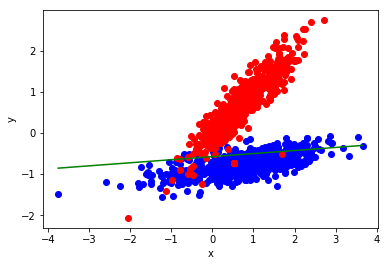

In [24]:
y_pred =  - (X[:, 0] * weights[0, 0]  + bias[0])/ weights[0, 1] 

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');

## Compare to built in Estimator LinearClassifier
using https://www.tensorflow.org/guide/premade_estimators#create_input_functions

In [25]:
features = {"X0":X[:,0], 'X1':X[:,1]}
labels = y.ravel()

In [26]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(10).repeat().batch(batch_size)


In [27]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in features.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[_NumericColumn(key='X0', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='X1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [28]:
#optimizer = tf.train.FtrlOptimizer(learning_rate=5.0, l2_regularization_strength=1.0)

estimator = tf.estimator.LinearClassifier(
    feature_columns=my_feature_columns, n_classes=NUM_FEATURES, 
    #optimizer=optimizer
)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpgvebfnfi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8f7e7accc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
BATCH_SIZE=100

In [30]:
estimator.train(
    input_fn=lambda:train_input_fn(features, labels, BATCH_SIZE),
    steps=400
)

# Evaluate and report metrics.
eval_metrics = estimator.evaluate(
    input_fn=lambda:train_input_fn(features, labels, BATCH_SIZE), 
    steps=1
)
print(eval_metrics)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpgvebfnfi/model.ckpt.
INFO:tensorflow:loss = 69.31474, step = 1
INFO:tensorflow:global_step/sec: 736.891
INFO:tensorflow:loss = 18.452694, step = 101 (0.136 sec)
INFO:tensorflow:global_step/sec: 1564.97
INFO:tensorflow:loss = 13.000765, step = 201 (0.064 sec)
INFO:tensorflow:global_step/sec: 1546.16
INFO:tensorflow:loss = 11.061689, step = 301 (0.065 sec)
INFO:tensorflow:Saving checkpoints for 400 into /tmp/tmpgvebfnfi/model.ckpt.
INFO:tensorflow:Loss for final step: 10.256347.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-18-13:18:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpgvebfnfi

In [31]:
w0 = estimator.get_variable_value('linear/linear_model/X0/weights')[0,0]
w1 = estimator.get_variable_value('linear/linear_model/X1/weights')[0,0]
bi = estimator.get_variable_value('linear/linear_model/bias_weights')[0]

w0, w1, bi, w0/w1, bi/w1

(1.3050847, -4.1039543, -1.4180816, -0.31800663, 0.34554031)

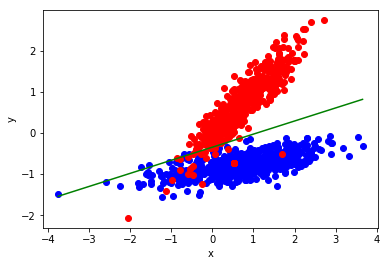

In [32]:
y_pred =  - (X[:, 0] * w0  + bi) / w1 
order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');